# Step 2: Compare Brain Scans & Extract Features

## Purpose
This notebook compares brain MRI scans between Demented and Nondemented groups, then extracts features for machine learning.

## What You'll Learn
1. How to load and process multiple brain scans
2. How to compare brain structures between groups
3. How to extract meaningful features from 3D brain images
4. How to prepare data for machine learning

## Prerequisites
Make sure you've completed Step 1 (explore_oasis_data.ipynb) first!


## Step 0: Install Required Libraries (Run This First!)

If you get "ModuleNotFoundError", run this cell first to install all required packages:

```python
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn nibabel openpyxl scipy
```

After running this, restart the kernel (Kernel > Restart) and then continue with the notebook.

## Step 1: Import Required Libraries

We'll use the same libraries as before, plus some additional ones for feature extraction.


In [2]:
# Install required packages (run this if you get ModuleNotFoundError)
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn nibabel openpyxl scipy


   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
    --------------------------------------- 0.5/38.6 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.0/38.6 MB 3.0 MB/s eta 0:00:13
   - -------------------------------------- 1.6/38.6 MB 2.9 MB/s eta 0:00:13
   -- ------------------------------------- 2.1/38.6 MB 2.9 MB/s eta 0:00:13
   -- ------------------------------------- 2.9/38.6 MB 2.9 MB/s eta 0:00:13
   --- ------------------------------------ 3.4/38.6 MB 2.9 MB/s eta 0:00:13
   ---- ----------------------------------- 3.9/38.6 MB 2.9 MB/s eta 0:00:13
   ---- ----------------------------------- 4.5/38.6 MB 2.8 MB/s eta 0:00:13
   ----- ---------------------------------- 5.0/38.6 MB 2.8 MB/s eta 0:00:13
   ----- ---------------------------------- 5.5/38.6 MB 2.8 MB/s eta 0:00:12
   ------ --------------------------------- 6.3/38.6 MB 2.8 MB/s eta 0:00:12
   ------ --------------------------------- 6.6/38.6 MB 2.7 MB/s eta 0:00:12
   ---


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Standard library imports
import os
import glob
import pickle  # For saving extracted features

# Third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from scipy import ndimage  # For image processing
from scipy.stats import ttest_ind  # For statistical comparisons

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully")


All libraries imported successfully


## Step 2: Load Metadata and Determine Groups

**Why this step matters**: We need to know which subjects are Demented vs Nondemented. In OASIS-1, we use the CDR (Clinical Dementia Rating) column:
- CDR = 0 → Nondemented (healthy)
- CDR > 0 → Demented (has dementia)

**What we're doing**: Loading the metadata and creating group labels based on CDR scores.


In [4]:
# Define data directory
data_dir = "Data"

# Load metadata
excel_path = os.path.join(data_dir, "oasis_cross-sectional.xlsx")
metadata_df = pd.read_excel(excel_path)

print(f"Loaded metadata for {len(metadata_df)} subjects")
print(f"Columns: {list(metadata_df.columns)}")
print("\nFirst few rows:")
print(metadata_df.head())


Loaded metadata for 436 subjects
Columns: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']

First few rows:
              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


In [5]:
# Find all subject folders (same as Step 1)
disc1_path = os.path.join(data_dir, "oasis_cross-sectional_disc1", "disc1")
disc12_path = os.path.join(data_dir, "oasis_cross-sectional_disc12", "disc12")

all_subject_folders = []
if os.path.exists(disc1_path):
    all_subject_folders.extend([os.path.join(disc1_path, d) 
                                for d in os.listdir(disc1_path) 
                                if os.path.isdir(os.path.join(disc1_path, d))])

if os.path.exists(disc12_path):
    all_subject_folders.extend([os.path.join(disc12_path, d) 
                                for d in os.listdir(disc12_path) 
                                if os.path.isdir(os.path.join(disc12_path, d))])

print(f"Found {len(all_subject_folders)} subject folders")


Found 75 subject folders


In [6]:
# Extract subject IDs from folder names
def extract_subject_id(folder_path):
    folder_name = os.path.basename(folder_path)
    subject_id = folder_name.replace("_MR1", "")
    return subject_id

subject_ids = [extract_subject_id(folder) for folder in all_subject_folders]

# Match with metadata
id_column = 'ID'
metadata_df['extracted_id'] = metadata_df[id_column].astype(str).str.replace('_MR1', '')
available_metadata = metadata_df[metadata_df['extracted_id'].isin(subject_ids)].copy()

print(f"Found metadata for {len(available_metadata)} subjects with scans")


Found metadata for 75 subjects with scans


Diagnosis distribution:
Diagnosis
Nondemented    52
Demented       23
Name: count, dtype: int64



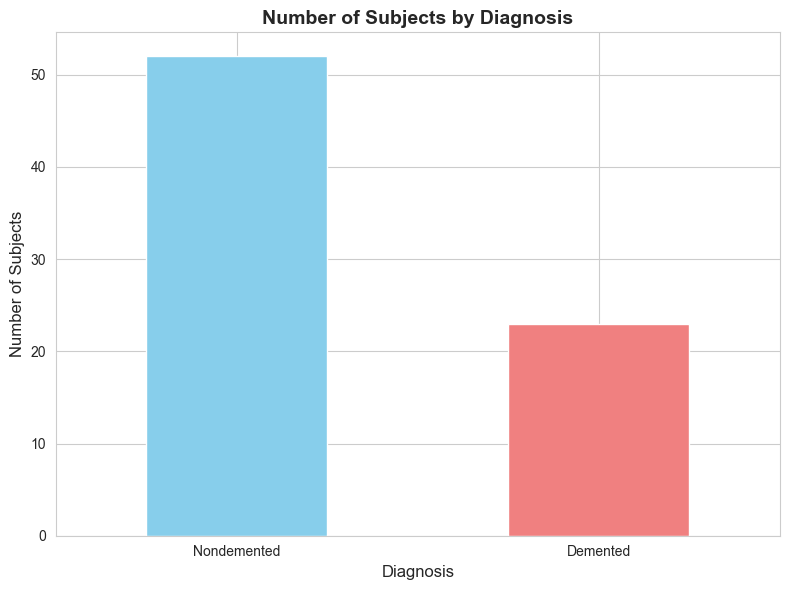

In [7]:
# Create diagnosis groups based on CDR
# CDR = 0 means no dementia (Nondemented)
# CDR > 0 means dementia (Demented)
available_metadata['Diagnosis'] = available_metadata['CDR'].apply(
    lambda x: 'Demented' if x > 0 else 'Nondemented'
)

# Check the distribution
diagnosis_counts = available_metadata['Diagnosis'].value_counts()
print("Diagnosis distribution:")
print(diagnosis_counts)
print()

# Visualize
plt.figure(figsize=(8, 6))
diagnosis_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Number of Subjects by Diagnosis', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Number of Subjects', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('diagnosis_distribution_step2.png', dpi=150)
plt.show()


## Step 3: Load Brain Scans for Both Groups

**Why this step matters**: We need to load the actual brain scan data for each subject so we can compare them and extract features.

**What we're doing**: 
- Finding and loading .hdr files for each subject
- Storing them in separate lists for Demented and Nondemented groups
- Creating a mapping between subject IDs and their scan data


In [9]:
# Function to find and load a brain scan for a subject
def load_brain_scan(subject_folder):
    """
    Load brain scan from subject folder.
    Returns the 3D brain data array, or None if not found.
    """
    # Check RAW subdirectory first
    raw_folder = os.path.join(subject_folder, "RAW")
    if os.path.exists(raw_folder):
        hdr_files = glob.glob(os.path.join(raw_folder, "*.hdr"))
    else:
        hdr_files = glob.glob(os.path.join(subject_folder, "*.hdr"))
    
    if len(hdr_files) == 0:
        return None
    
    try:
        brain_img = nib.load(hdr_files[0])
        brain_data = brain_img.get_fdata()
        return brain_data
    except Exception as e:
        print(f"Error loading scan from {subject_folder}: {e}")
        return None

print("Function defined successfully")


Function defined successfully


In [10]:
# Create a mapping from subject ID to folder path
subject_id_to_folder = {}
for folder in all_subject_folders:
    subject_id = extract_subject_id(folder)
    subject_id_to_folder[subject_id] = folder

# Separate subjects by diagnosis
nondemented_subjects = available_metadata[available_metadata['Diagnosis'] == 'Nondemented']
demented_subjects = available_metadata[available_metadata['Diagnosis'] == 'Demented']

print(f"Nondemented subjects: {len(nondemented_subjects)}")
print(f"Demented subjects: {len(demented_subjects)}")


Nondemented subjects: 52
Demented subjects: 23


In [11]:
# Load brain scans for both groups
# Note: This may take a few minutes as we're loading many 3D images

nondemented_scans = []
nondemented_ids = []

demented_scans = []
demented_ids = []

print("Loading Nondemented scans...")
for idx, row in nondemented_subjects.iterrows():
    subject_id = row['extracted_id']
    if subject_id in subject_id_to_folder:
        scan = load_brain_scan(subject_id_to_folder[subject_id])
        if scan is not None:
            nondemented_scans.append(scan)
            nondemented_ids.append(subject_id)

print(f"Loaded {len(nondemented_scans)} Nondemented scans")

print("\nLoading Demented scans...")
for idx, row in demented_subjects.iterrows():
    subject_id = row['extracted_id']
    if subject_id in subject_id_to_folder:
        scan = load_brain_scan(subject_id_to_folder[subject_id])
        if scan is not None:
            demented_scans.append(scan)
            demented_ids.append(subject_id)

print(f"Loaded {len(demented_scans)} Demented scans")

print(f"\nTotal scans loaded: {len(nondemented_scans) + len(demented_scans)}")


Loading Nondemented scans...
Loaded 52 Nondemented scans

Loading Demented scans...
Loaded 23 Demented scans

Total scans loaded: 75


## Step 4: Compare Brain Scans - Visual Comparison

**Why this step matters**: Visual comparison helps us understand what differences exist between Demented and Nondemented brains before we extract numerical features.

**What we're doing**: 
- Creating average brain images for each group
- Visualizing differences between groups
- Looking at specific brain regions that are known to be affected by Alzheimer's


In [12]:
# Create average brain images for each group
# This shows us the "typical" brain structure for each group

if len(nondemented_scans) > 0 and len(demented_scans) > 0:
    # Stack all scans into a 4D array (subjects, x, y, z)
    nondemented_stack = np.stack(nondemented_scans, axis=0)
    demented_stack = np.stack(demented_scans, axis=0)
    
    # Calculate mean across subjects (axis 0)
    nondemented_mean = np.mean(nondemented_stack, axis=0)
    demented_mean = np.mean(demented_stack, axis=0)
    
    print(f"Nondemented average shape: {nondemented_mean.shape}")
    print(f"Demented average shape: {demented_mean.shape}")
    
    # Calculate difference image
    difference = nondemented_mean - demented_mean
    
    print("\nAverage images created successfully!")


Nondemented average shape: (256, 256, 128, 1)
Demented average shape: (256, 256, 128, 1)

Average images created successfully!


Saved: brain_comparison_average.png


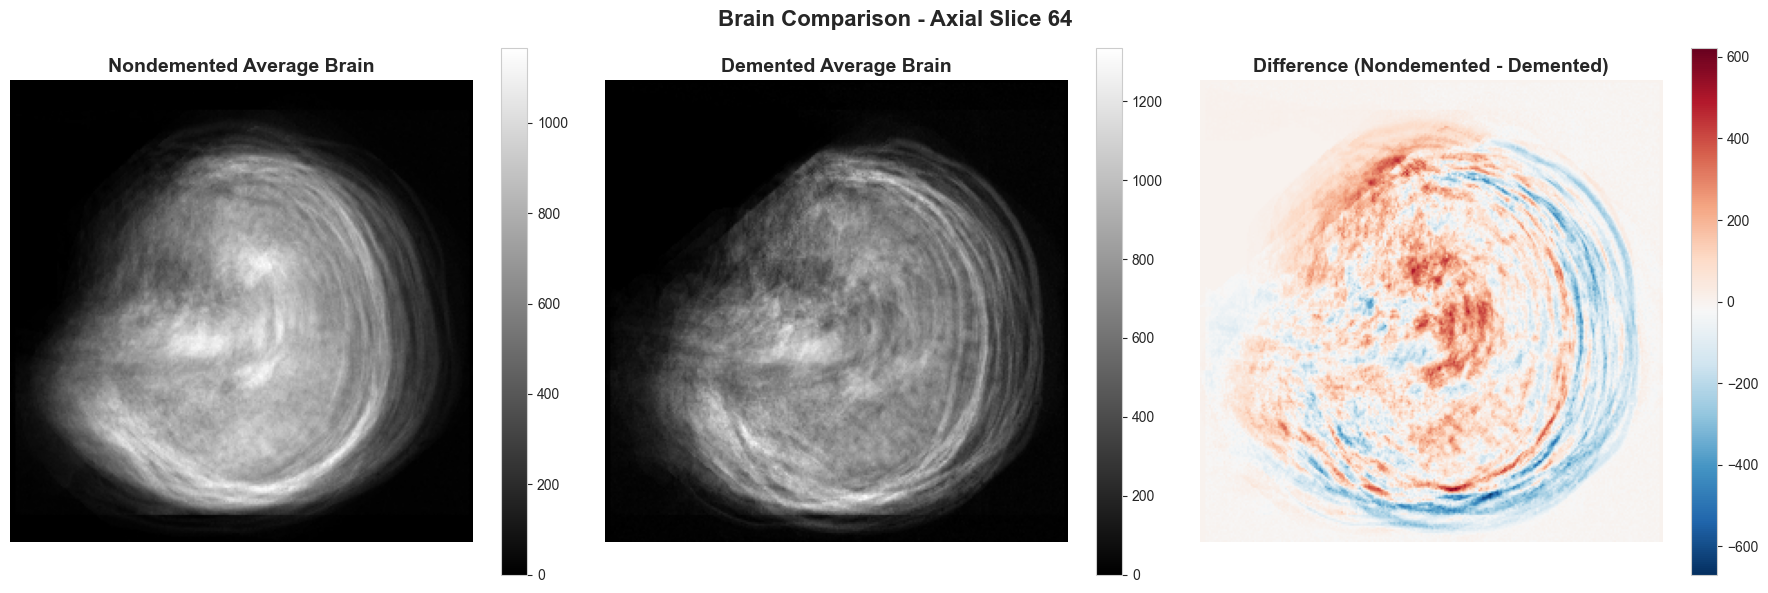

In [13]:
# Visualize average brains side by side
if len(nondemented_scans) > 0 and len(demented_scans) > 0:
    # Get middle slice for visualization
    z_mid = nondemented_mean.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Nondemented average
    im1 = axes[0].imshow(nondemented_mean[:, :, z_mid], cmap='gray', origin='lower')
    axes[0].set_title('Nondemented Average Brain', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0])
    
    # Demented average
    im2 = axes[1].imshow(demented_mean[:, :, z_mid], cmap='gray', origin='lower')
    axes[1].set_title('Demented Average Brain', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1])
    
    # Difference (Nondemented - Demented)
    # Positive values = Nondemented has more tissue
    # Negative values = Demented has more tissue
    im3 = axes[2].imshow(difference[:, :, z_mid], cmap='RdBu_r', origin='lower')
    axes[2].set_title('Difference (Nondemented - Demented)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2])
    
    plt.suptitle(f'Brain Comparison - Axial Slice {z_mid}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('brain_comparison_average.png', dpi=150, bbox_inches='tight')
    print("Saved: brain_comparison_average.png")
    plt.show()


## Step 5: Extract Features from Brain Scans

**Why this step matters**: Raw 3D brain images are too large and complex for most machine learning algorithms. We need to extract meaningful numerical features that capture important information about brain structure.

**What we're extracting**:
1. **Volume-based features**: Total brain volume, tissue volumes
2. **Morphological features**: Brain shape characteristics
3. **Statistical features**: Mean, std, percentiles of intensity values
4. **Regional features**: Features from specific brain regions (simplified for now)


In [14]:
# Function to extract features from a single brain scan
def extract_brain_features(brain_data):
    """
    Extract numerical features from a 3D brain scan.
    
    Parameters:
    -----------
    brain_data : numpy array
        3D array representing brain scan (x, y, z)
    
    Returns:
    --------
    features : dict
        Dictionary of extracted features
    """
    features = {}
    
    # 1. Basic statistics
    features['mean_intensity'] = np.mean(brain_data)
    features['std_intensity'] = np.std(brain_data)
    features['min_intensity'] = np.min(brain_data)
    features['max_intensity'] = np.max(brain_data)
    features['median_intensity'] = np.median(brain_data)
    
    # 2. Percentiles (useful for understanding intensity distribution)
    features['p25_intensity'] = np.percentile(brain_data, 25)
    features['p75_intensity'] = np.percentile(brain_data, 75)
    features['p90_intensity'] = np.percentile(brain_data, 90)
    
    # 3. Volume-based features (assuming non-zero voxels represent brain tissue)
    # Create a binary mask (non-zero = brain tissue)
    brain_mask = brain_data > 0
    features['total_volume'] = np.sum(brain_mask)  # Number of brain voxels
    
    # 4. Intensity-based volume (weighted by intensity)
    features['weighted_volume'] = np.sum(brain_data[brain_mask])
    
    # 5. Spatial features (brain dimensions)
    features['shape_x'] = brain_data.shape[0]
    features['shape_y'] = brain_data.shape[1]
    features['shape_z'] = brain_data.shape[2]
    
    # 6. Regional features (simplified - using quadrants)
    x_mid = brain_data.shape[0] // 2
    y_mid = brain_data.shape[1] // 2
    z_mid = brain_data.shape[2] // 2
    
    # Left vs Right hemisphere (simplified)
    left_hemisphere = brain_data[:x_mid, :, :]
    right_hemisphere = brain_data[x_mid:, :, :]
    left_mask = left_hemisphere > 0
    right_mask = right_hemisphere > 0
    if np.sum(left_mask) > 0:
        features['left_hemisphere_mean'] = np.mean(left_hemisphere[left_mask])
    else:
        features['left_hemisphere_mean'] = 0
    if np.sum(right_mask) > 0:
        features['right_hemisphere_mean'] = np.mean(right_hemisphere[right_mask])
    else:
        features['right_hemisphere_mean'] = 0
    features['hemisphere_asymmetry'] = abs(features['left_hemisphere_mean'] - features['right_hemisphere_mean'])
    
    # Front vs Back
    front_region = brain_data[:, :y_mid, :]
    back_region = brain_data[:, y_mid:, :]
    front_mask = front_region > 0
    back_mask = back_region > 0
    if np.sum(front_mask) > 0:
        features['front_region_mean'] = np.mean(front_region[front_mask])
    else:
        features['front_region_mean'] = 0
    if np.sum(back_mask) > 0:
        features['back_region_mean'] = np.mean(back_region[back_mask])
    else:
        features['back_region_mean'] = 0
    
    # Top vs Bottom
    top_region = brain_data[:, :, z_mid:]
    bottom_region = brain_data[:, :, :z_mid]
    top_mask = top_region > 0
    bottom_mask = bottom_region > 0
    if np.sum(top_mask) > 0:
        features['top_region_mean'] = np.mean(top_region[top_mask])
    else:
        features['top_region_mean'] = 0
    if np.sum(bottom_mask) > 0:
        features['bottom_region_mean'] = np.mean(bottom_region[bottom_mask])
    else:
        features['bottom_region_mean'] = 0
    
    return features

print("Feature extraction function defined")


Feature extraction function defined


In [15]:
# Extract features for all scans
print("Extracting features from Nondemented scans...")
nondemented_features = []
for i, scan in enumerate(nondemented_scans):
    features = extract_brain_features(scan)
    features['subject_id'] = nondemented_ids[i]
    features['diagnosis'] = 'Nondemented'
    nondemented_features.append(features)
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(nondemented_scans)} scans")

print(f"\nExtracting features from Demented scans...")
demented_features = []
for i, scan in enumerate(demented_scans):
    features = extract_brain_features(scan)
    features['subject_id'] = demented_ids[i]
    features['diagnosis'] = 'Demented'
    demented_features.append(features)
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(demented_scans)} scans")

print(f"\nTotal features extracted: {len(nondemented_features) + len(demented_features)}")


Extracting features from Nondemented scans...
  Processed 10/52 scans
  Processed 20/52 scans
  Processed 30/52 scans
  Processed 40/52 scans
  Processed 50/52 scans

Extracting features from Demented scans...
  Processed 10/23 scans
  Processed 20/23 scans

Total features extracted: 75


In [16]:
# Convert to pandas DataFrame for easier analysis
all_features = nondemented_features + demented_features
features_df = pd.DataFrame(all_features)

print(f"Features DataFrame shape: {features_df.shape}")
print(f"\nColumns: {list(features_df.columns)}")
print("\nFirst few rows:")
print(features_df.head())


Features DataFrame shape: (75, 22)

Columns: ['mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'median_intensity', 'p25_intensity', 'p75_intensity', 'p90_intensity', 'total_volume', 'weighted_volume', 'shape_x', 'shape_y', 'shape_z', 'left_hemisphere_mean', 'right_hemisphere_mean', 'hemisphere_asymmetry', 'front_region_mean', 'back_region_mean', 'top_region_mean', 'bottom_region_mean', 'subject_id', 'diagnosis']

First few rows:
   mean_intensity  std_intensity  min_intensity  max_intensity  \
0      305.590931     570.658549            0.0         4095.0   
1      287.270149     580.278431            0.0         4095.0   
2      333.769605     557.945749            0.0         4095.0   
3      334.832586     524.467379            0.0         4095.0   
4      269.952090     549.703063            0.0         4095.0   

   median_intensity  p25_intensity  p75_intensity  p90_intensity  \
0               0.0            0.0          331.0         1134.0   
1             

## Step 6: Compare Features Between Groups

**Why this step matters**: We want to see which features are significantly different between Demented and Nondemented groups. These features are likely to be useful for classification.

**What we're doing**: 
- Comparing feature distributions between groups
- Performing statistical tests to find significant differences
- Visualizing the most important features


In [17]:
# Compare feature distributions
# Get numeric feature columns (exclude subject_id and diagnosis)
feature_cols = [col for col in features_df.columns 
                if col not in ['subject_id', 'diagnosis']]

print(f"Comparing {len(feature_cols)} features between groups...")
print()

# Statistical comparison for each feature
comparison_results = []

for feature in feature_cols:
    nondemented_values = features_df[features_df['diagnosis'] == 'Nondemented'][feature].dropna()
    demented_values = features_df[features_df['diagnosis'] == 'Demented'][feature].dropna()
    
    if len(nondemented_values) > 0 and len(demented_values) > 0:
        # T-test to compare means
        t_stat, p_value = ttest_ind(nondemented_values, demented_values)
        
        comparison_results.append({
            'feature': feature,
            'nondemented_mean': nondemented_values.mean(),
            'demented_mean': demented_values.mean(),
            'difference': nondemented_values.mean() - demented_values.mean(),
            'p_value': p_value,
            'significant': p_value < 0.05
        })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('p_value')

print("Top 10 most significantly different features:")
print(comparison_df.head(10).to_string(index=False))


Comparing 20 features between groups...

Top 10 most significantly different features:
          feature  nondemented_mean  demented_mean    difference  p_value  significant
    p75_intensity      3.713846e+02   4.095217e+02 -3.813712e+01 0.282526        False
 median_intensity      1.353846e+01   2.604348e+01 -1.250502e+01 0.299877        False
   mean_intensity      3.027799e+02   3.180741e+02 -1.529422e+01 0.330706        False
  weighted_volume      2.539902e+09   2.668199e+09 -1.282972e+08 0.330706        False
     total_volume      3.388627e+06   3.639378e+06 -2.507517e+05 0.339804        False
    p25_intensity      1.173077e+00   3.391304e+00 -2.218227e+00 0.350108        False
    p90_intensity      1.113308e+03   1.143348e+03 -3.004013e+01 0.569258        False
    std_intensity      5.420708e+02   5.543849e+02 -1.231406e+01 0.630961        False
    max_intensity      3.948558e+03   4.024130e+03 -7.557274e+01 0.636947        False
front_region_mean      7.938136e+02   8.117

c:\Users\muhabah\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


C:\Users\muhabah\AppData\Local\Temp\ipykernel_45100\1028996597.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_to_plot, labels=['Nondemented', 'Demented'])
C:\Users\muhabah\AppData\Local\Temp\ipykernel_45100\1028996597.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_to_plot, labels=['Nondemented', 'Demented'])
C:\Users\muhabah\AppData\Local\Temp\ipykernel_45100\1028996597.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_to_plot, labels=['Nondemented', 'Demented'])
C:\Users\muhabah\AppData\Local\Temp\ipykernel_45100\1028996597.py:15: Matplotli

Saved: feature_comparison.png


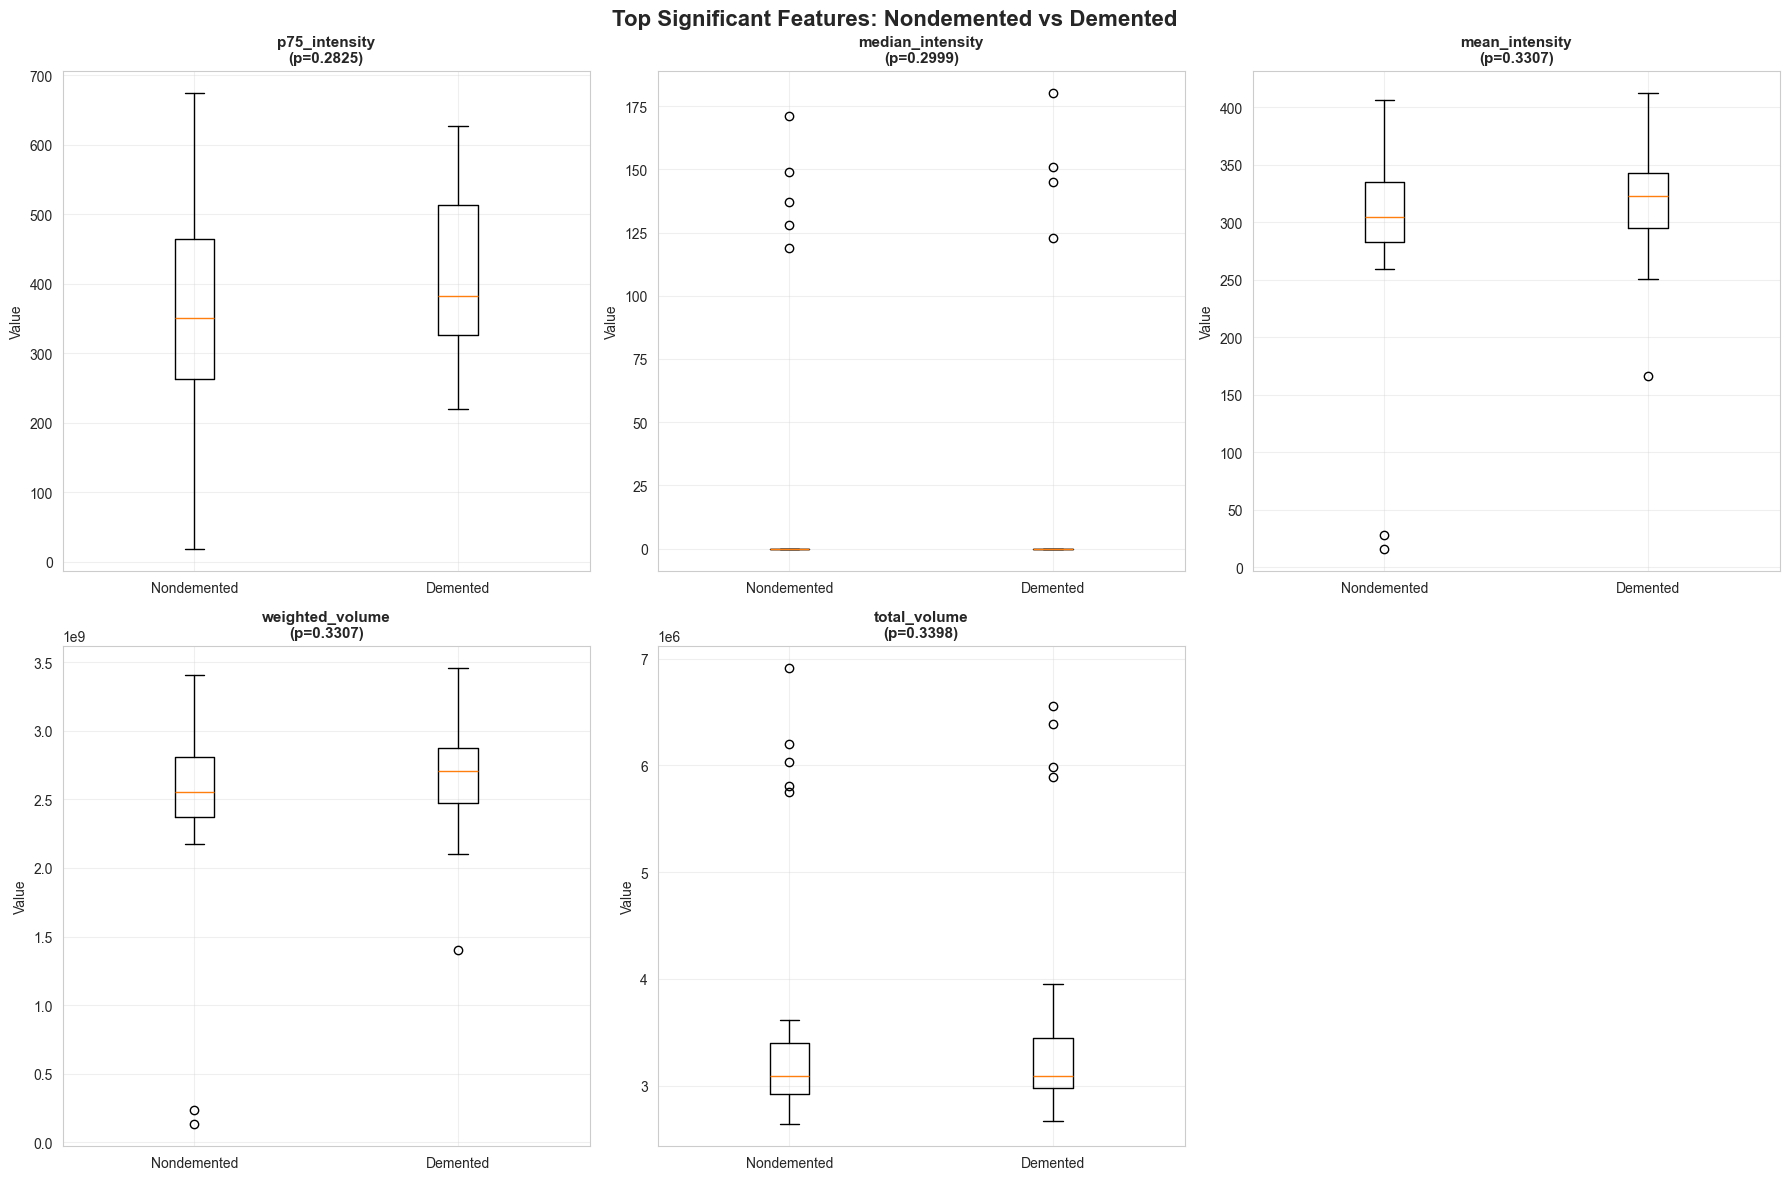

In [18]:
# Visualize top 5 most significant features
top_features = comparison_df.head(5)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features[:6]):  # Show up to 6 features
    if i < len(axes):
        # Box plot
        data_to_plot = [
            features_df[features_df['diagnosis'] == 'Nondemented'][feature].dropna(),
            features_df[features_df['diagnosis'] == 'Demented'][feature].dropna()
        ]
        
        axes[i].boxplot(data_to_plot, labels=['Nondemented', 'Demented'])
        axes[i].set_title(f"{feature}\n(p={comparison_df[comparison_df['feature']==feature]['p_value'].values[0]:.4f})", 
                         fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Value', fontsize=10)
        axes[i].grid(True, alpha=0.3)

# Remove extra subplot if needed
if len(top_features) < 6:
    fig.delaxes(axes[5])

plt.suptitle('Top Significant Features: Nondemented vs Demented', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_comparison.png', dpi=150, bbox_inches='tight')
print("Saved: feature_comparison.png")
plt.show()


## Step 7: Save Extracted Features

**Why this step matters**: We'll use these features in the next notebook for machine learning. Saving them now means we don't have to re-extract them every time.

**What we're saving**:
- Features DataFrame (CSV format for easy viewing)
- Features DataFrame (pickle format for Python)
- Comparison results (CSV format)


## Summary


In [19]:
# Save features DataFrame
features_df.to_csv('extracted_features.csv', index=False)
print("Saved: extracted_features.csv")

# Also save as pickle (preserves data types better)
with open('extracted_features.pkl', 'wb') as f:
    pickle.dump(features_df, f)
print("Saved: extracted_features.pkl")

# Save comparison results
comparison_df.to_csv('feature_comparison_results.csv', index=False)
print("Saved: feature_comparison_results.csv")

print("\nAll features saved successfully!")


Saved: extracted_features.csv
Saved: extracted_features.pkl
Saved: feature_comparison_results.csv

All features saved successfully!


## Summary

**What we accomplished**:
1. Loaded and organized brain scans by diagnosis group
2. Created average brain images and compared them visually
3. Extracted numerical features from all brain scans
4. Compared features between groups to find significant differences
5. Saved features for use in machine learning

**Generated files**:
- `diagnosis_distribution_step2.png` - Diagnosis group distribution
- `brain_comparison_average.png` - Visual comparison of average brains
- `feature_comparison.png` - Box plots of top significant features
- `extracted_features.csv` - All extracted features (CSV format)
- `extracted_features.pkl` - All extracted features (Python pickle format)
- `feature_comparison_results.csv` - Statistical comparison results

**Next steps**:
- Use the extracted features to build a machine learning classifier
- Train models to predict Demented vs Nondemented
- Evaluate model performance
